In [18]:
import string
import re
import os
import nltk
import pandas as pd
import numpy as np
import json
import glob
import gzip
import tensorflow as tf
from tensorflow import keras
import time

import matplotlib.pyplot as plt

SEED = 1013
np.random.seed(SEED)

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import pandas as pd 
import numpy as np 
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy import sparse
import os
import pickle
import emoji
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.util import ngrams

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Meghna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
covid_files_path = r'/Users/Meghna/Desktop/covid_data/covid_tweets.json'

covid_train_data = []
noncovid_train_data = []
covid_train_labels = []
noncovid_train_labels = []

covid_train_data2 = []
noncovid_train_data2 = []


try:
    with open(covid_files_path,'r') as fin:
        for line in fin:
            tweet = json.loads(line)
            covid_train_data.append(tweet['text'])
            covid_train_labels.append(1)
except:
    print("Faulty file ")

In [3]:
noncovid_files_path = r'/Users/Meghna/Desktop/noncovid_data/*'
noncovid_files = glob.glob(noncovid_files_path)
num_noncovid_tweets = 0

for i in range(len(noncovid_files)):
    print("opening file", noncovid_files[i])
    try:
        with gzip.open(noncovid_files[i],'r') as fin:
            for line in fin:
                if num_noncovid_tweets < 27068:
                    tweet = json.loads(line)
                    noncovid_train_data.append(tweet['text'])
                    noncovid_train_labels.append(0)
                    num_noncovid_tweets += 1

    except:
        print("Faulty file ", noncovid_files[i])

opening file /Users/Meghna/Desktop/noncovid_data/noncovid_tweets_oct.gz
opening file /Users/Meghna/Desktop/noncovid_data/noncovid_tweets_nov.gz


In [4]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    stripped = re.sub(r'\@w+','',stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [5]:
for tweet in covid_train_data:
    covid_train_data2.append(tweet_cleaner_updated(tweet))
    
for ntweet in noncovid_train_data:
    noncovid_train_data2.append(tweet_cleaner_updated(ntweet))

train_data = covid_train_data2 + noncovid_train_data2
train_labels = covid_train_labels + noncovid_train_labels

/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:421: MarkupResemblesLocatorWarning: "https://t.co/NSl7vPwMob
SCUMBAG." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


In [6]:
my_df = pd.DataFrame(columns=['text','target'])
my_df['text'] = train_data
my_df['target'] = train_labels
my_df.head()

,text,target
0,under covid restrictions domestic violence rat...,1
1,very interesting,1
2,on tiktok fans are making their own ratatouill...,1
3,why should you switch to http http seoul worst...,1
4,check out the covid chronicles by the cape cru...,1


In [7]:
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer()

In [8]:
len(cvec.get_feature_names())

48803

In [9]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [10]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
the,25749,20180,45929
to,18233,14827,33060
and,13770,10116,23886
china,22876,306,23182
in,12289,8104,20393
of,10955,9247,20202
is,10430,6534,16964
for,6776,6514,13290
it,6674,5025,11699
you,7334,4360,11694


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(my_df.text)

CountVectorizer(max_features=10000, stop_words='english')

In [12]:
document_matrix = cvec.transform(my_df.text)

In [13]:
neg_doc_matrix2 = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix2 = cvec.transform(my_df[my_df.target == 1].text)
neg_tf2 = np.sum(neg_doc_matrix2,axis=0)
pos_tf2 = np.sum(pos_doc_matrix2,axis=0)
neg2 = np.squeeze(np.asarray(neg_tf2))
pos2 = np.squeeze(np.asarray(pos_tf2))
term_freq_df2 = pd.DataFrame([neg2,pos2],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:30]

,negative,positive,total
china,22876,306,23182
covid,0,9930,9930
people,1939,2105,4044
trump,3099,653,3752
just,2059,1514,3573
like,2195,1266,3461
pandemic,102,3041,3143
vaccine,39,2832,2871
nba,2578,17,2595
lockdown,1242,1157,2399


In [14]:
train_corpus,test_corpus,train_labels,test_labels = train_test_split(train_data,train_labels,stratify=train_labels,test_size=0.25,random_state=1)
train_texts, train_labels, test_texts, test_labels = train_corpus, train_labels, test_corpus, test_labels
x_train, y_train, x_validation, y_validation = train_corpus,train_labels,test_corpus,test_labels

In [15]:
y_train_len0 = 0
y_train_len1 = 1
for label in y_train:
    if label == 1:
        y_train_len1 += 1
    else:
        y_train_len0 += 1
        
y_val_len0 = 0
y_val_len1 = 0
for label in y_validation:
    if label == 1:
        y_val_len1 += 1
    else:
        y_val_len0 += 1
        

In [16]:
print( "Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (y_train_len0 / (len(x_train)*1.))*100,
                                                                            (y_train_len1 / (len(x_train)*1.))*100))
       
                                                                            
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (y_val_len0 / (len(x_validation)))*100,
                                                                            (y_val_len1 / (len(x_validation)))*100))

Train set has total 40602 entries with 50.00% negative, 50.00% positive
Validation set has total 13534 entries with 50.00% negative, 50.00% positive


In [17]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if y_val_len0 / (len(x_test)*1.) > 0.5:
        null_accuracy =  y_val_len1/ (len(x_test)*1.)
    else:
        null_accuracy = 1. - (y_val_len1 / (len(x_test)*1.))
    #t0 = time.time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    #train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    #print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy

In [21]:
from sklearn.pipeline import Pipeline
cvec = CountVectorizer()
lr = MultinomialNB()
n_features = np.arange(10000,48001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy))
    return result

In [22]:
from sklearn.feature_extraction import text
z = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:3].index))
c = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[4:11].index))
listofsets = [z,c]
a = frozenset.union(*listofsets)
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

True

In [23]:
my_stop_words = a

In [24]:
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

MultinomialNB()


Validation result for 10000 features
null accuracy: 50.00%
accuracy score: 89.26%
model is 39.26% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.00%
accuracy score: 89.37%
model is 39.37% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.00%
accuracy score: 89.46%
model is 39.46% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 50.00%
accuracy score: 89.51%
model is 39.51% more accurate than null accuracy
--------------------------------------------------------------------------------


In [25]:
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

MultinomialNB()


Validation result for 10000 features
null accuracy: 50.00%
accuracy score: 89.35%
model is 39.35% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.00%
accuracy score: 89.46%
model is 39.46% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.00%
accuracy score: 89.47%
model is 39.47% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 50.00%
accuracy score: 89.48%
model is 39.48% more accurate than null accuracy
--------------------------------------------------------------------------------


In [26]:
print("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)

MultinomialNB()


Validation result for 10000 features
null accuracy: 50.00%
accuracy score: 89.34%
model is 39.34% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.00%
accuracy score: 89.57%
model is 39.57% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.00%
accuracy score: 89.63%
model is 39.63% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 50.00%
accuracy score: 89.52%
model is 39.52% more accurate than null accuracy
--------------------------------------------------------------------------------


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


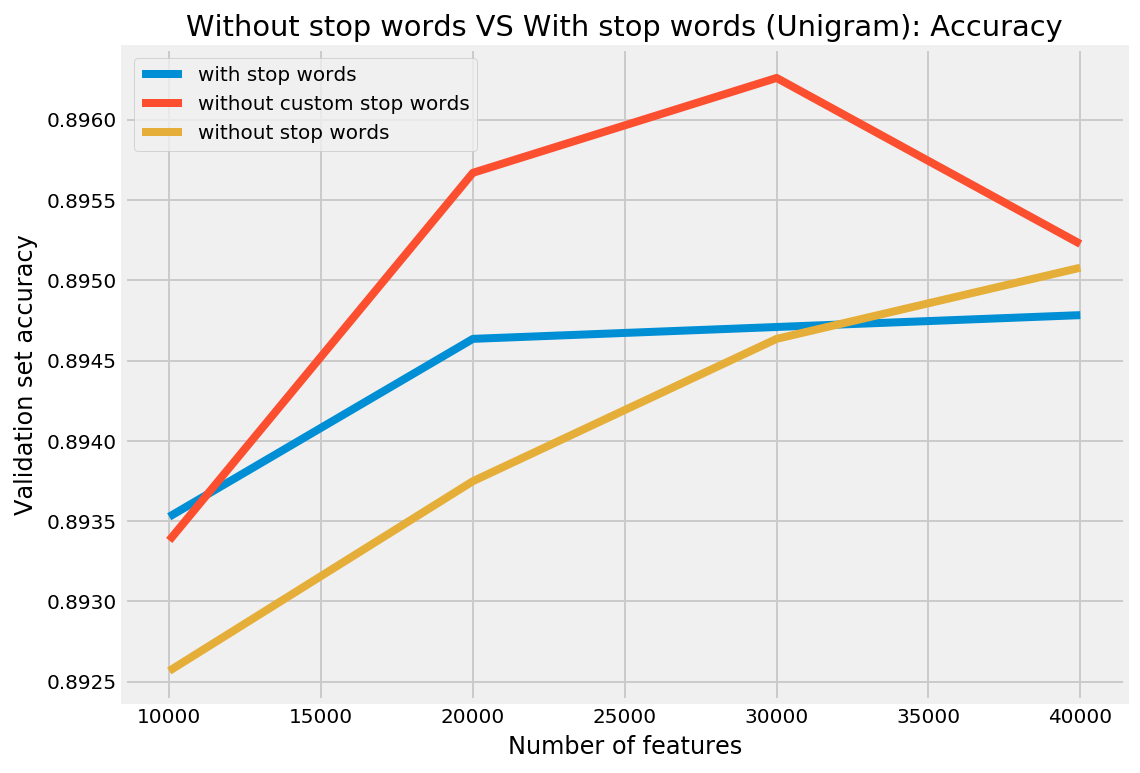

In [27]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [29]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Tfidf)\n")
feature_result_ugt = nfeature_accuracy_checker(stop_words = my_stop_words,vectorizer=tvec)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Tfidf)

MultinomialNB()


Validation result for 10000 features
null accuracy: 50.00%
accuracy score: 88.01%
model is 38.01% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.00%
accuracy score: 88.27%
model is 38.27% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.00%
accuracy score: 88.31%
model is 38.31% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 50.00%
accuracy score: 88.29%
model is 38.29% more accurate than null accuracy
--------------------------------------------------------------------------------
CPU times: user 4.37 s, sys: 94.7 ms, total: 4.47 s
Wall time: 4.52 s


In [30]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS (Tfidf)\n")
feature_result_ugt2 = nfeature_accuracy_checker(stop_words = 'english',vectorizer=tvec)

RESULT FOR UNIGRAM WITHOUT STOP WORDS (Tfidf)

MultinomialNB()


Validation result for 10000 features
null accuracy: 50.00%
accuracy score: 88.08%
model is 38.08% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.00%
accuracy score: 88.24%
model is 38.24% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.00%
accuracy score: 88.42%
model is 38.42% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 50.00%
accuracy score: 88.39%
model is 38.39% more accurate than null accuracy
--------------------------------------------------------------------------------
CPU times: user 3.9 s, sys: 67.8 ms, total: 3.97 s
Wall time: 4 s


In [31]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_ugt3 = nfeature_accuracy_checker(vectorizer=tvec)

RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)

MultinomialNB()


Validation result for 10000 features
null accuracy: 50.00%
accuracy score: 87.99%
model is 37.99% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.00%
accuracy score: 88.22%
model is 38.22% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.00%
accuracy score: 88.24%
model is 38.24% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 50.00%
accuracy score: 88.22%
model is 38.22% more accurate than null accuracy
--------------------------------------------------------------------------------
CPU times: user 4.18 s, sys: 85.2 ms, total: 4.27 s
Wall time: 4.29 s


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


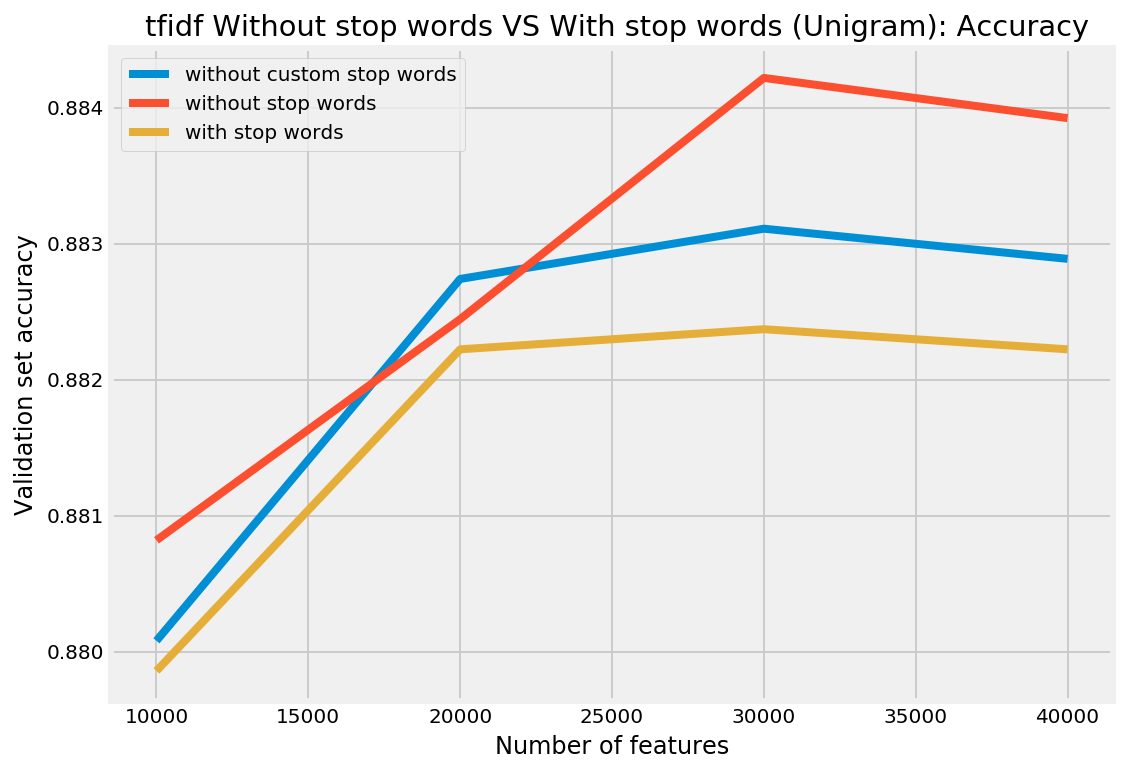

In [32]:
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt2 = pd.DataFrame(feature_result_ugt2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt3 = pd.DataFrame(feature_result_ugt3,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='without custom stop words')
plt.plot(nfeatures_plot_ugt2.nfeatures, nfeatures_plot_ugt2.validation_accuracy,label='without stop words')
plt.plot(nfeatures_plot_ugt3.nfeatures, nfeatures_plot_ugt3.validation_accuracy,label='with stop words')
plt.title(" tfidf Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()